In [15]:
import tensorflow as tf
tf.random.set_seed(10)
import tensorflow_datasets as tfds
dataset, dataset_info = tfds.load(name='malaria', shuffle_files=True, with_info=True, as_supervised=True, split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'])

In [16]:
# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])  # Resize images to 224x224
    image = tf.cast(image, tf.float32)  # Convert images to float32
    return image, label

# Apply preprocessing
train_dataset, valid_dataset, test_dataset = dataset

train_dataset = train_dataset.map(preprocess)
valid_dataset = valid_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

# Normalization function
def normalise(image, label):
    return image / 255, label

# Apply normalization
train_dataset = train_dataset.map(normalise)
valid_dataset = valid_dataset.map(normalise)
test_dataset = test_dataset.map(normalise)

# Apply shuffling, batching, and prefetching
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

2024-09-02 12:17:09.506383: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


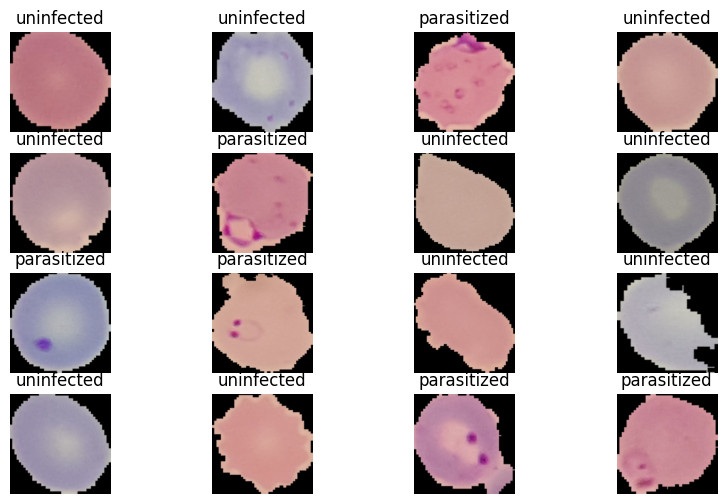

In [17]:
import matplotlib.pyplot as plt
for i, (images, labels) in enumerate(train_dataset.take(1)):
    plt.figure(figsize=(10,6))
    for j in range(16):
        ax = plt.subplot(4, 4, j + 1)
        ax.imshow(images[j].numpy())
        label = labels[j].numpy()
        ax.set_title(dataset_info.features['label'].int2str(label))
        ax.axis('off')
plt.show()

In [18]:
def visualaize(image,agImg,k=2):
    for i in range(k):
        plt.subplot(1,2,1)
        plt.imshow(image[i])
        plt.subplot(1,2,2)
        plt.imshow(agImg[i])
        plt.show()

In [19]:
image,label=next(iter(train_dataset))

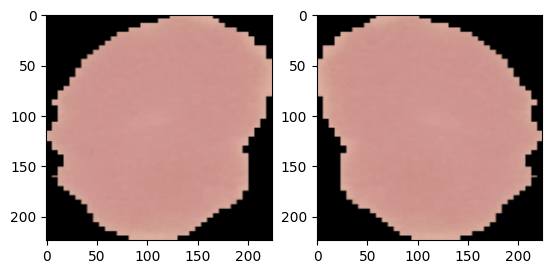

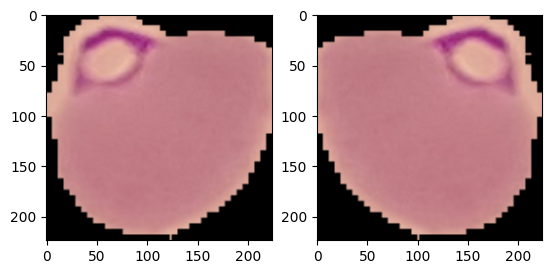

In [20]:
agImage,label = tf.image.flip_left_right(image),label
visualaize(image,agImage)

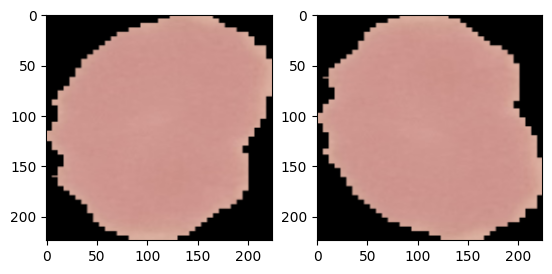

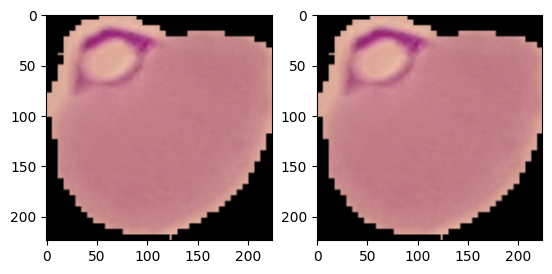

In [21]:
agFlip = tf.image.random_flip_up_down(image)
visualaize(image,agFlip)

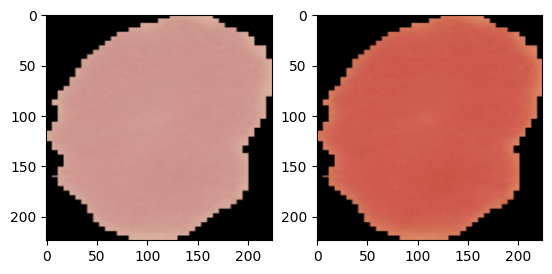

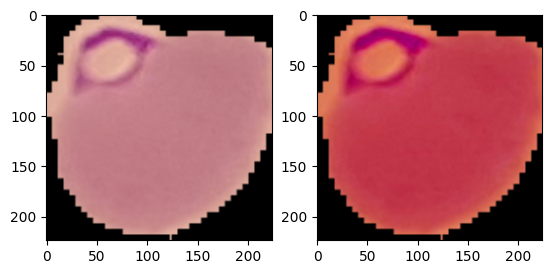

In [22]:
agSat = tf.image.adjust_saturation(image,saturation_factor=2.0)
visualaize(image,agSat)

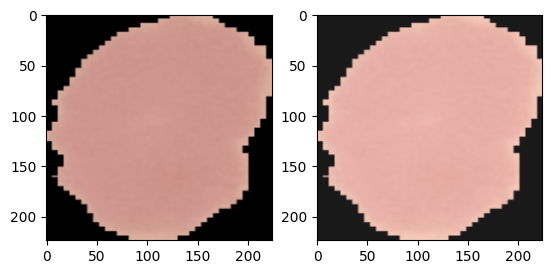

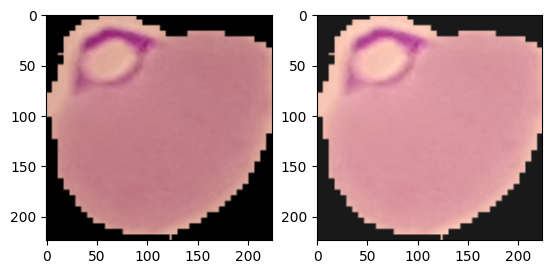

In [23]:
agBri = tf.image.adjust_brightness(image,delta=.1)
visualaize(image,agBri)

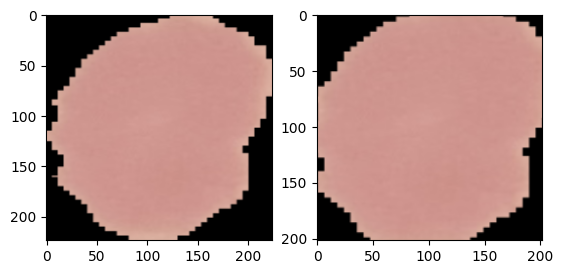

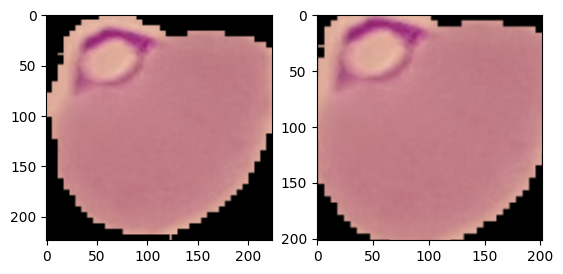

In [24]:
agCc = tf.image.central_crop(image,central_fraction=.9)
visualaize(image,agCc)

# Augumentation

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Dataset loading and preprocessing (as in your code)
dataset, dataset_info = tfds.load(name='malaria', shuffle_files=True, with_info=True, as_supervised=True, split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'])

def augument(image, label):
    image = tf.image.rot90(image)
    image = tf.image.adjust_saturation(image, saturation_factor=2.0)
    image = tf.image.central_crop(image, central_fraction=0.9)
    image = tf.image.adjust_brightness(image, delta=0.2)
    return image, label

def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])  # Resize images to 224x224
    image = tf.cast(image, tf.float32)  # Convert images to float32
    return image / 255, label

train_dataset, valid_dataset, test_dataset = dataset

train_dataset = train_dataset.map(augument).map(preprocess)
valid_dataset = valid_dataset.map(augument).map(preprocess)
test_dataset = test_dataset.map(preprocess)

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [26]:
from tensorflow.keras.callbacks import LearningRateScheduler
def scheduler(epoch,lr):
    if epoch < 3 :
        return lr
    else:
        return float(lr* tf.math.exp(-0.1))
sched = LearningRateScheduler(scheduler,verbose = 1)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model with debug prints for output shapes
model = models.Sequential()

model.add(layers.InputLayer(shape=(224, 224, 3)))

model.add(layers.Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(strides=2))
print(model.output_shape)  # (None, 111, 111, 6)

model.add(layers.Conv2D(filters=18, kernel_size=3, strides=1, padding='valid', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(strides=2))
print(model.output_shape)  # (None, 54, 54, 18)

model.add(layers.Conv2D(filters=36, kernel_size=3, strides=1, padding='valid', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(strides=2))
print(model.output_shape)  # (None, 26, 26, 36)

model.add(layers.Conv2D(filters=48, kernel_size=3, strides=1, padding='valid', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(strides=2))
print(model.output_shape)  # (None, 12, 12, 48)

model.add(layers.Flatten())
print(model.output_shape)  # (None, 6912)

# Adjust the Dense layer to match the Flatten output
model.add(layers.Dense(602, activation='relu'))  # Adjust to match the output of the Flatten layer
model.add(layers.Dense(680, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

# Model Compilation
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])

# Assuming train_dataset and valid_dataset are defined as shown earlier
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=20,callbacks=[sched])

(None, 111, 111, 6)
(None, 54, 54, 18)
(None, 26, 26, 36)
(None, 12, 12, 48)
(None, 6912)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 18)   │           990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 18)   │            72 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 36)     │         5,868 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 52, 52, 36)     │           144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 36)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 48)     │        15,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6912)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 602)            │     4,161,626 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 680)            │       410,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           681 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,595,405 (17.53 MB)

 Trainable params: 4,595,189 (17.53 MB)

 Non-trainable params: 216 (864.00 B)


Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 193s 274ms/step - accuracy: 0.8018 - loss: 0.4815 - val_accuracy: 0.9238 - val_loss: 0.2327 - learning_rate: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 183s 265ms/step - accuracy: 0.9490 - loss: 0.1535 - val_accuracy: 0.9347 - val_loss: 0.1895 - learning_rate: 5.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 183s 265ms/step - accuracy: 0.9614 - loss: 0.1173 - val_accuracy: 0.9441 - val_loss: 0.1805 - learning_rate: 5.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00045241869520395994.
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 15118s 22s/step - accuracy: 0.9701 - loss: 0.0832 - val_accuracy: 0.9140 - val_loss: 0.3083 - learning_rate: 4.5242e-04

Epoch 5: LearningRateScheduler setting

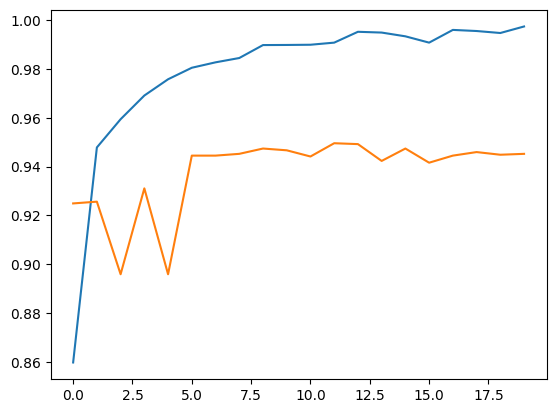

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [1]:
def my_decorator(func):
    def wrapper():
        print("Something is happening before the function is called.")
        func()
        print("Something is happening after the function is called.")
    return wrapper

@my_decorator
def say_hello():
    print("Hello!")

say_hello()

Something is happening before the function is called.
Hello!
Something is happening after the function is called.
